In [12]:
from scipy.optimize import minimize, differential_evolution
import numpy as np
import pandas as pd
import sys
import os

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from tqdm.notebook import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (6,4) 
import json

from pyballistics import ozvb_lagrange
from pyballistics import get_powder_names

# %config InlineBackend.figure_format = 'svg' 
%matplotlib inline

viridis = cm.get_cmap('Blues_r', 1024)
newcolors = viridis(np.linspace(0, 1, 1024))
newcolors[:52, :] = cm.get_cmap('winter_r', 52)(np.linspace(0.0, 0.5, 52))
newcmp = ListedColormap(newcolors)


In [13]:
def getPsr(res):
    PS = list()
    for layer in res['layers']:
        xs = layer['x']
        x_c = (xs[:-1]+xs[1:])/2
        ps = layer['p']
        S = np.sum(0.5*(x_c[1:]-x_c[:-1])*(ps[1:]+ps[:-1]))
        p = S / (x_c[-1] - x_c[0])
        PS.append(p)
    return PS

In [14]:
def full_calc(otn_m_z, delta, porox, n):

    q = 3.3
    omega = q * otn_m_z
    W_0 = omega/delta
    d = 0.0762
    n_S = 1.04
    opts = {
              'powders': [{'omega': omega, 'dbname': porox}],
              'init_conditions': {
                  'q': q,
                   'd': d,
                   'W_0': W_0,
                   'phi_1': 1.04,
                   'p_0': 30e6,
                    'n_S': n_S
                    },
              'igniter': {'p_ign_0': 5e6},
              'heat':{'enabled':True, 'heat_barrel':True},
              'windage':{'shock_wave':True},
                'meta_lagrange': {
                    'n_cells': n, 
                    'CFL': 0.7},
                'stop_conditions': {
               'steps_max': 100000,  
                    'x_p': 65*d,
                    'p_max':380e6,
                    'v_p': 1000
                    }
                 }
    
    res20 = ozvb_lagrange(opts)
    results = {
     'n': n
    }

        
    if res20['stop_reason'] != 'v_p':
        results['criteria'] = 99  
        
        return results

    opts['init_conditions']['T_0'] = 273.15 - 50
    opts['stop_conditions'] = {
        'x_p': res20['layers'][-1]['x'][-1], 
        'steps_max': 100000
            }
      
    res50 = ozvb_lagrange(opts)
    
    
    
    if res50['stop_reason'] != 'x_p':
        results['criteria'] = 99
        
        return results
    
    
    
    PSR50 = getPsr(res50)
    
    if PSR50[-1] > 150e6:
        results['criteria'] = 99 
    
        return results
    

    results['criteria'] = W_0 + res20['layers'][-1]['x'][-1] * n_S * np.pi * d ** 2 /4
        
    
    return results



def plot_results(results):
    
    plt.figure(figsize=(6,6), dpi = 600)
    
    x1 = []
    y1 = []
    
    x2 = []
    y2 = []
    
    x3 = []
    y3 = []

    for res in results['res1']:
        x1.append(res['n'])
        y1.append(res['criteria'])
    
    for res in results['res2']:
        x2.append(res['n'])
        y2.append(res['criteria'])
        
    for res in results['res3']:
        x3.append(res['n'])
        y3.append(res['criteria'])
        
    plt.plot(x1, y1, label = '$W_{pm}$ в точке $(\\omega/q, \\Delta)$', zorder=3)
    plt.plot(x2, y2, label = '$W_{pm}$ в точке $(\\omega/q+\\delta_{\\omega/q}, \\Delta)$', zorder=3)
    plt.plot(x3, y3, label = '$W_{pm}$ в точке $(\\omega/q, \\Delta+\\delta_{\\Delta})$', zorder=3)
                
    plt.xlabel('Количество ячеек')
    plt.ylabel('$W_{pm}, м^{3}$')
    plt.legend()
    plt.grid()
    plt.show()

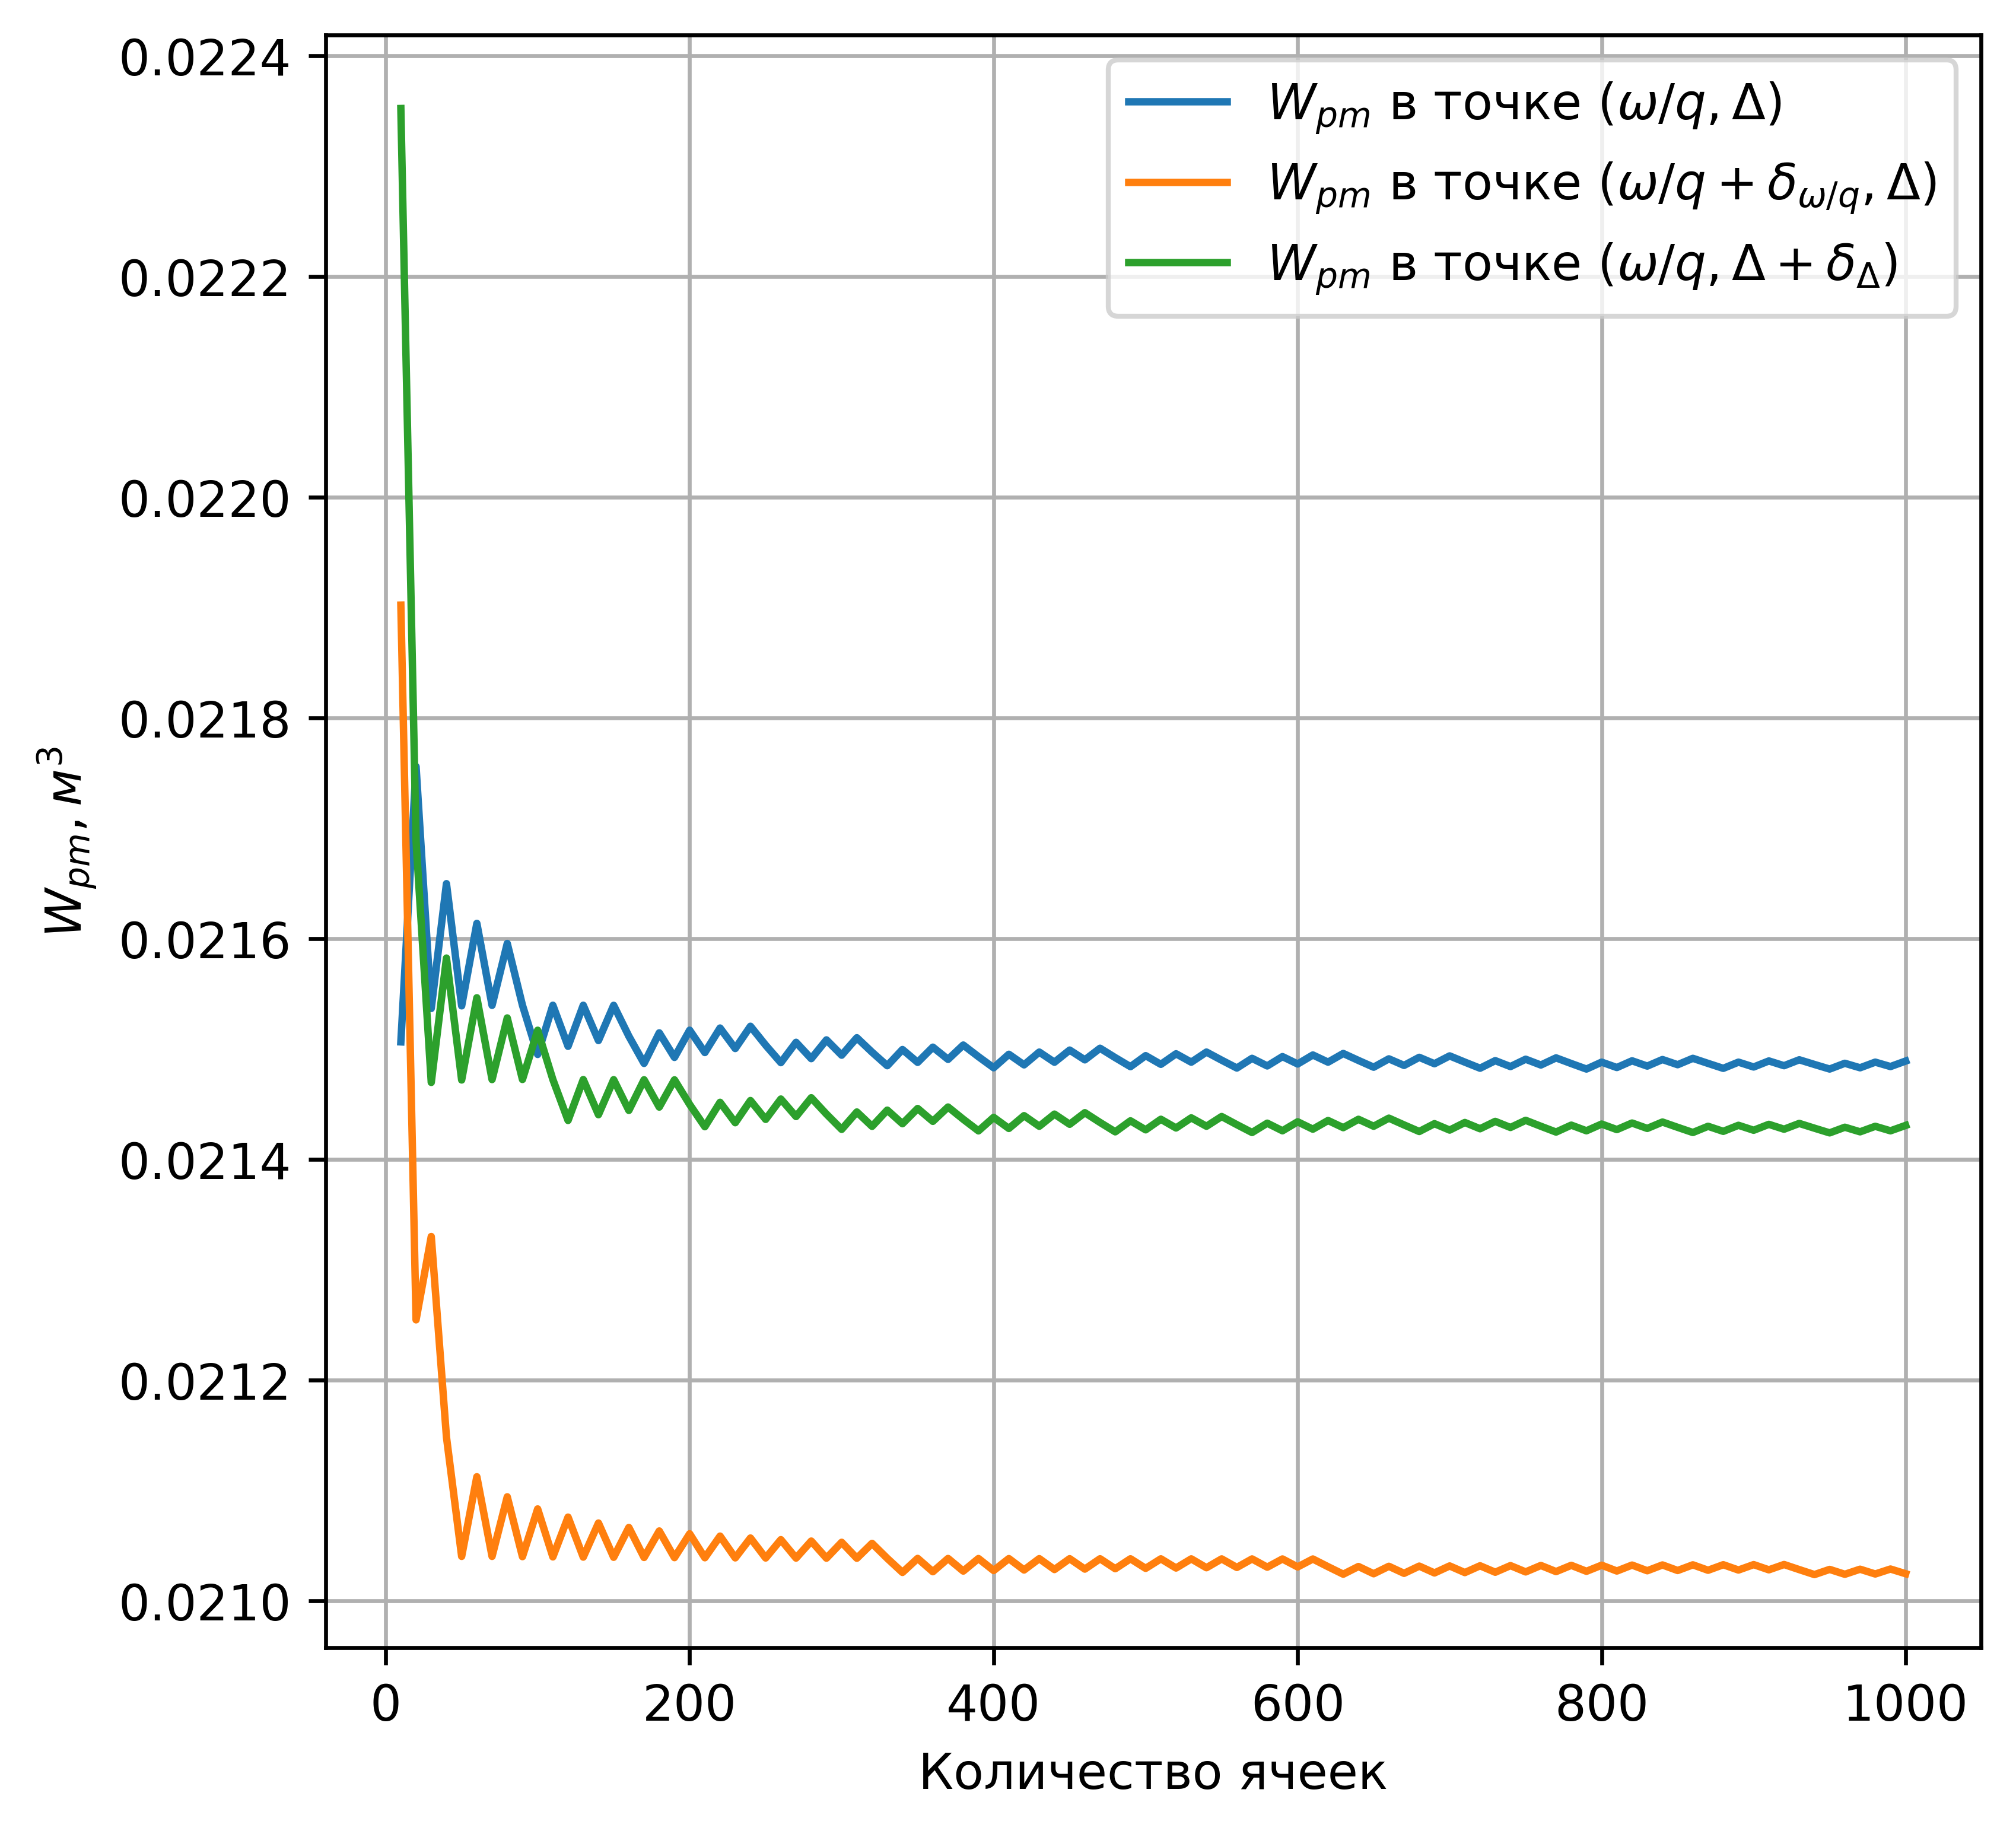

In [15]:
porox = '9/7'

results = {}
results1 = []
results2 = []
results3 = []

otn_m_z = 0.358801
delta = 779.979866

sh_po_wq = 0.002
sh_po_delta = 1
n = 10

while n <= 1000:
    res1 = full_calc(otn_m_z, delta, porox, n)
    results1.append(res1)
    n += 10
results['res1'] = results1


otn_m_z = otn_m_z + sh_po_wq

n = 10

while n <= 1000:
    res2 = full_calc(otn_m_z, delta, porox, n)
    results2.append(res2)
    n += 10
results['res2'] = results2


otn_m_z = 0.358801
delta = delta + sh_po_delta

n = 10

while n <= 1000:
    res3 = full_calc(otn_m_z, delta, porox, n)
    results3.append(res3)
    n += 10
results['res3'] = results3

               
plot_results(results)

In [16]:
results

{'res1': [{'n': 10, 'criteria': 0.021506564004000302},
  {'n': 20, 'criteria': 0.021756056313769187},
  {'n': 30, 'criteria': 0.02153685919139791},
  {'n': 40, 'criteria': 0.021649933139098496},
  {'n': 50, 'criteria': 0.0215392179806987},
  {'n': 60, 'criteria': 0.021613967767442805},
  {'n': 70, 'criteria': 0.02153965847006507},
  {'n': 80, 'criteria': 0.02159575994638846},
  {'n': 90, 'criteria': 0.02153975799865166},
  {'n': 100, 'criteria': 0.02149517456535835},
  {'n': 110, 'criteria': 0.02153977438273181},
  {'n': 120, 'criteria': 0.021502551550363323},
  {'n': 130, 'criteria': 0.02153977202076299},
  {'n': 140, 'criteria': 0.021507777652085676},
  {'n': 150, 'criteria': 0.021539707580837803},
  {'n': 160, 'criteria': 0.021511705587087333},
  {'n': 170, 'criteria': 0.02148705203818391},
  {'n': 180, 'criteria': 0.02151474898444011},
  {'n': 190, 'criteria': 0.02149249423431978},
  {'n': 200, 'criteria': 0.02151715762248753},
  {'n': 210, 'criteria': 0.021496905564349564},
  {'n'